<a href="https://colab.research.google.com/github/riya-chougule/Image_segmentation_for_self_driving_cars_using_deep_learning_techniques/blob/main/Trial_and_error.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/My Drive/Kaggle"

In [ ]:
from pathlib import Path
from fastai.vision import *
import wandb
from wandb.fastai import WandbCallback
from functools import partialmethod

In [ ]:
wandb.init(project="semantic-segmentation")

<IPython.core.display.Javascript object>

In [ ]:
config = wandb.config           # for shortening
config.framework = "fast.ai"    
config.img_size = (360, 640)    # dimensions of resized image - can be 1 dim or tuple
config.batch_size = 4           # Batch size during training
config.epochs = 20              # Number of epochs for training
encoder = models.resnet18       
config.encoder = encoder.__name__
config.pretrained = True       
config.weight_decay = 1e-4      # weight decay applied on layers
config.bn_weight_decay = False  
config.one_cycle = True        
config.learning_rate = 3e-3     # learning rate
save_model = True

In [ ]:
config.training_stages = 2
path_data = Path('../data/bdd100k/seg')
path_lbl = path_data / 'labels'
path_img = path_data / 'images'

path_data = Path('/content/drive/MyDrive/Kaggle/bdd100k_seg/bdd100k/seg')
path_lbl = path_data / 'labels'
path_img = path_data / 'images'

get_y_fn = lambda x: path_lbl / x.parts[-2] / f'{x.stem}_train_id.png'

In [ ]:
segmentation_classes = [
    'road', 'sidewalk', 'building', 'wall', 'fence', 'pole', 'traffic light',
    'traffic sign', 'vegetation', 'terrain', 'sky', 'person', 'rider', 'car',
    'truck', 'bus', 'train', 'motorcycle', 'bicycle', 'void'
]
void_code = 19

In [ ]:
src = (SegmentationItemList.from_folder(path_img).use_partial_data(0.01)
       .split_by_folder(train='train', valid='val')
       .label_from_func(get_y_fn, classes=segmentation_classes))
data = (src.transform(get_transforms(), size=config.img_size, tfm_y=True)
        .databunch(bs=config.batch_size)
        .normalize(imagenet_stats))

In [ ]:
def acc(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask] == target[mask]).float().mean()
    
learn = unet_learner(
data,arch=encoder,
pretrained=config.pretrained,
metrics=acc,
wd=config.weight_decay,
bn_wd=config.bn_weight_decay,
callback_fns=partial(WandbCallback, save_model=save_model, monitor='acc', input_type='images'))

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [ ]:
if config.one_cycle:
    learn.fit_one_cycle(
        config.epochs // 2,
        max_lr=slice(config.learning_rate))
    learn.unfreeze()
    learn.fit_one_cycle(
        config.epochs // 2,
        max_lr=slice(config.learning_rate / 100,
                     config.learning_rate / 10))
else:
    learn.fit(
        config.epochs,
        lr=slice(config.learning_rate))

epoch,train_loss,valid_loss,acc,time
0,2.399174,2.220103,0.284606,01:06
1,2.105051,2.100922,0.405279,00:32
2,2.096658,2.035797,0.429165,00:32
3,2.017672,1.915809,0.409055,00:31
4,1.967184,1.966636,0.249821,00:31
5,1.923464,1.769131,0.509566,00:31
6,1.813840,1.778444,0.489588,00:31
7,1.729845,1.594964,0.518066,00:31
8,1.617006,1.475424,0.592698,00:31
9,1.506231,1.435447,0.596425,00:31


Better model found at epoch 0 with acc value: 0.2846059799194336.
Better model found at epoch 1 with acc value: 0.405278742313385.
Better model found at epoch 2 with acc value: 0.4291645884513855.
Better model found at epoch 5 with acc value: 0.5095657110214233.
Better model found at epoch 7 with acc value: 0.5180655717849731.
Better model found at epoch 8 with acc value: 0.5926980376243591.
Better model found at epoch 9 with acc value: 0.5964248776435852.
Loaded best saved model from /content/wandb/run-20210526_125550-2vfvh11e/files/bestmodel.pth


epoch,train_loss,valid_loss,acc,time
0,1.255990,1.408722,0.605875,00:33
1,1.233575,1.393086,0.619912,00:32
2,1.205306,1.276626,0.645633,00:32
3,1.184868,1.300114,0.630539,00:32
4,1.148266,1.179488,0.705582,00:32
5,1.095412,1.136443,0.697530,00:32
6,1.041057,1.120337,0.685672,00:32
7,1.006285,1.093858,0.708527,00:32
8,0.963839,1.102877,0.710967,00:32
9,0.920818,1.097057,0.712575,00:32


Better model found at epoch 0 with acc value: 0.6058748364448547.
Better model found at epoch 1 with acc value: 0.6199115514755249.
Better model found at epoch 2 with acc value: 0.6456326246261597.
Better model found at epoch 4 with acc value: 0.7055818438529968.
Better model found at epoch 7 with acc value: 0.7085267901420593.
Better model found at epoch 8 with acc value: 0.7109671831130981.
Better model found at epoch 9 with acc value: 0.7125750184059143.
Loaded best saved model from /content/wandb/run-20210526_125550-2vfvh11e/files/bestmodel.pth


In [ ]:
learn.export()
path = Path('/content/drive/MyDrive/Kaggle/bdd100k_seg/bdd100k/seg/images')
path.ls()

[PosixPath('/content/drive/MyDrive/Kaggle/bdd100k_seg/bdd100k/seg/images/test'),
 PosixPath('/content/drive/MyDrive/Kaggle/bdd100k_seg/bdd100k/seg/images/train'),
 PosixPath('/content/drive/MyDrive/Kaggle/bdd100k_seg/bdd100k/seg/images/val'),
 PosixPath('/content/drive/MyDrive/Kaggle/bdd100k_seg/bdd100k/seg/images/models'),
 PosixPath('/content/drive/MyDrive/Kaggle/bdd100k_seg/bdd100k/seg/images/export.pkl')]

In [ ]:
path
learn_inf = load_learner(path)

In [ ]:
learn_inf = load_learner(path)


In [ ]:
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

In [ ]:
from PIL import Image as PImage
from fastai.vision import *
frame=cv2.imread("/content/drive/MyDrive/Kaggle/bdd100k_seg/bdd100k/seg/images/test/ae7bcd76-00000000.jpg")
frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
pil_im = PImage.fromarray(frame) 
x = pil2tensor(pil_im ,np.float32)
preds_num = learn_inf.predict(Image(x))[2].numpy()

In [ ]:
len(preds_num)

20

In [ ]:
preds_num

In [ ]:
preds_num.shape

(20, 360, 640)

In [ ]:
im1=(preds_num[2:3])
im1

array([[[0.000000e+00, 0.000000e+00, 0.000000e+00, 6.165559e-40, ..., 0.000000e+00, 0.000000e+00, 0.000000e+00,
         0.000000e+00],
        [0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00, 0.000000e+00, 0.000000e+00,
         0.000000e+00],
        [0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00, 0.000000e+00, 0.000000e+00,
         0.000000e+00],
        [0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00, 0.000000e+00, 0.000000e+00,
         0.000000e+00],
        ...,
        [0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 2.329043e-21, 1.393813e-23, 1.656833e-33,
         2.107761e-34],
        [0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 8.002659e-25, 5.878700e-26, 3.468239e-33,
         2.309918e-37],
        [0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 5.200212e-32, 6.916947e-31, 1.407579e-30,
         8.413061e-39],
        [0.000000e+00, 0.000000e+00

In [ ]:
im1.shape

(1, 360, 640)

In [ ]:
sliced= im1[0,:,:]
sliced

array([[0.000000e+00, 0.000000e+00, 0.000000e+00, 6.165559e-40, ..., 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00],
       ...,
       [0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 2.329043e-21, 1.393813e-23, 1.656833e-33,
        2.107761e-34],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 8.002659e-25, 5.878700e-26, 3.468239e-33,
        2.309918e-37],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 5.200212e-32, 6.916947e-31, 1.407579e-30,
        8.413061e-39],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, 

In [ ]:
sliced.shape

(360, 640)

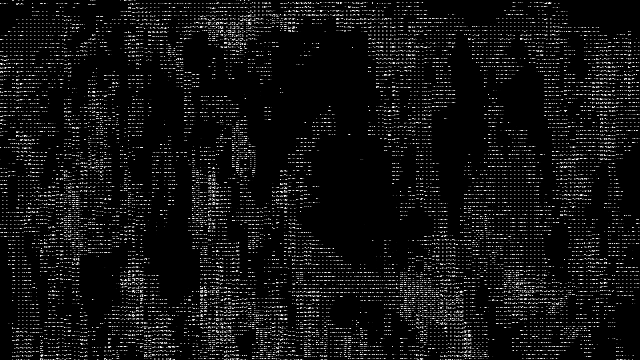

In [ ]:
result=PIL.Image.fromarray(sliced,"L")
result

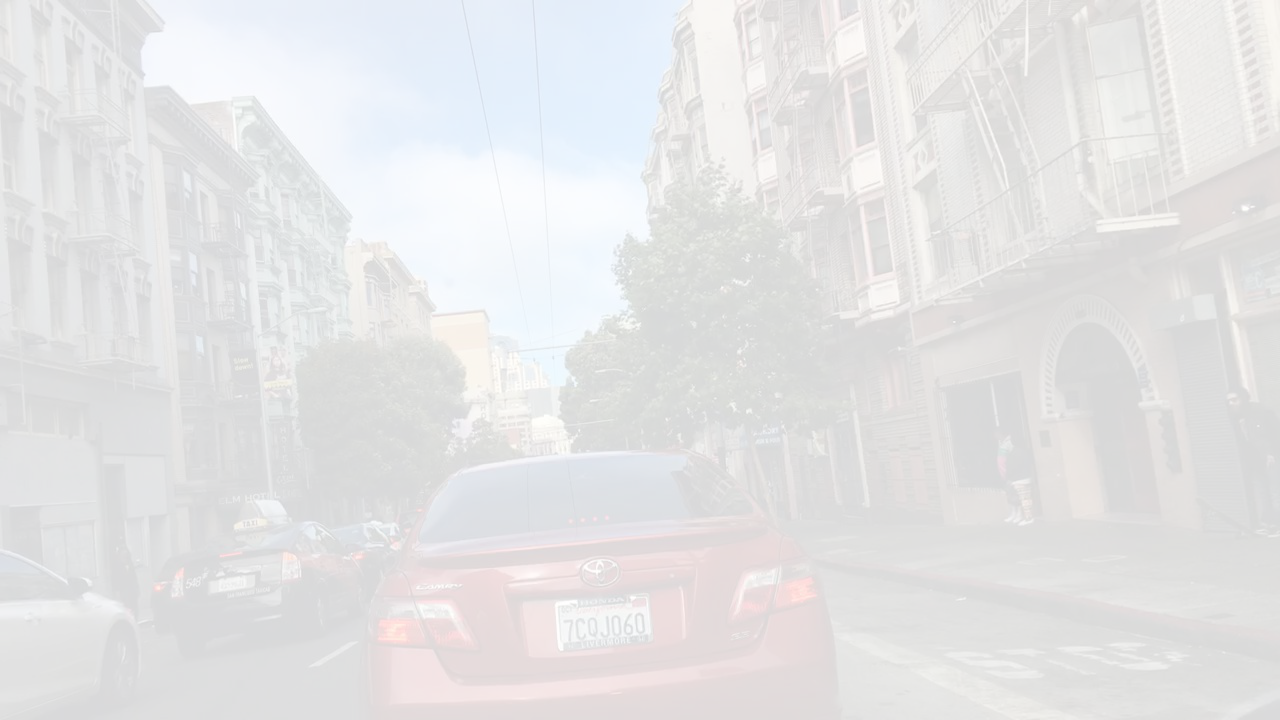

In [ ]:
img1=Image.open("/content/drive/MyDrive/Kaggle/bdd100k_seg/bdd100k/seg/images/test/ae7bcd76-00000000.jpg")
im_rgba = img1.copy()
im_rgba.putalpha(128)
#im_rgba.save('data/dst/pillow_putalpha_solid.png')
im_rgba